##DeBERTa-v3-base - Environmental Claim Detection - Binary Classification (yes/no)


In [1]:
!pip install -q "transformers>=4.44,<5" "datasets>=2.19" "evaluate>=0.4" accelerate \
                 pandas scikit-learn numpy matplotlib sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00


In [2]:
import os, re, ast, json, time, gc, itertools
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
import evaluate

# Pre-processing

**Loading dataset, empty/duplicate rows removal, normalizing labels and applying text cleaner**

In [3]:
df = pd.read_excel("fully_annotated_data.xlsx")
df.dropna(subset=["text"], inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)
df['label'] = df['label'].str.lower().str.strip()
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,%-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
df['text_clean'] = df['text'].apply(clean_text)

**Parse taxonomy columns**
- If category/subcategory columns exist, we clean up “Unsure” labels by tying them to the parent where possible



In [4]:
if 'Categories' in df.columns and 'Subcategories' in df.columns:
    df['Categories']    = df['Categories'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    df['Subcategories'] = df['Subcategories'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    def rename_unsure(cat_list, parent_name):
        return [f"Unsure ({parent_name})" if str(label).strip().lower() == "unsure" else label for label in cat_list]
    for parent in ["Environment","Social Capital","Human Capital","Business Model & Innovation","Leadership & Governance"]:
        df['Categories'] = df.apply(
            lambda row: rename_unsure(row.get('Categories', []), parent) if parent in row.get('Categories', []) else row.get('Categories', []),
            axis=1
        )
        df['Subcategories'] = df.apply(
            lambda row: rename_unsure(row.get('Subcategories', []), parent) if parent in row.get('Categories', []) else row.get('Subcategories', []),
            axis=1
        )
    df['all_labels'] = df['Categories'] + df['Subcategories']

**Train/val/test splits for claim detection**

In [5]:
claim_detection_df = df[['text_clean','label']].copy()
X = claim_detection_df['text_clean']
y = claim_detection_df['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

**HuggingFace Datasets, tokenization and metrics**
- Wrap splits as HuggingFace Datasets, define the DeBERTa-v3 tokenizer, and set up accuracy/F1 so the Trainer can report consistent scores

In [6]:
ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
label_names = ["no","tie","yes"]
label2id_cls = {l:i for i,l in enumerate(label_names)}
id2label_cls = {i:l for l,i in label2id_cls.items()}
train_base = Dataset.from_dict({"text": X_train.tolist(), "label": [label2id_cls[v] for v in y_train]})
val_base   = Dataset.from_dict({"text": X_val .tolist(), "label": [label2id_cls[v] for v in y_val]})
test_base  = Dataset.from_dict({"text": X_test.tolist(), "label": [label2id_cls[v] for v in y_test]})
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"],
        "weighted_f1": f1.compute(predictions=preds, references=p.label_ids, average="weighted")["f1"],
    }
def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
def tok_with_len(max_len):
    return lambda ex: tokenizer(ex["text"], truncation=True, max_length=max_len)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# Hyper-parameter Tuning

In [7]:
#Hyperparameter Grid (8 trials)
grid = {
    "learning_rate":  [1e-5, 2e-5],
    "per_device_train_batch_size": [8, 16],
    "num_train_epochs": [4, 6],
    "weight_decay": [0.01],
    "warmup_ratio": [0.06],
    "max_length": [256],
}
param_combos = list(itertools.product(
    grid["learning_rate"],
    grid["per_device_train_batch_size"],
    grid["num_train_epochs"],
    grid["weight_decay"],
    grid["warmup_ratio"],
    grid["max_length"],
))
print(f"Total trials: {len(param_combos)}")

Total trials: 8


**Tuning Loop**
- no checkpoints; best-val from logs

In [8]:
run_tag = datetime.now().strftime("%Y%m%d_%H%M%S")
out_root = f"tuning_debertav3_{run_tag}"
os.makedirs(out_root, exist_ok=True)
results = []
for i, (lr, bsz, epochs, wd, warmup, max_len) in enumerate(param_combos, start=1):
    trial = f"t{i:03d}_lr{lr}_bs{bsz}_ep{epochs}_wd{wd}_wr{warmup}_ml{max_len}"
    out_dir = os.path.join(out_root, trial)
    print(f"\n=== {trial} ===")
    set_seed(42)
    train_ds = train_base.map(tok_with_len(max_len), batched=True)
    val_ds   = val_base.map(tok_with_len(max_len),   batched=True)
    test_ds  = test_base.map(tok_with_len(max_len),  batched=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        ckpt, num_labels=3, id2label=id2label_cls, label2id=label2id_cls
    )
    eval_bsz = min(32, max(16, bsz))
    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=lr,
        per_device_train_batch_size=bsz,
        per_device_eval_batch_size=eval_bsz,
        num_train_epochs=epochs,
        weight_decay=wd,
        warmup_ratio=warmup,
        eval_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        save_safetensors=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        logging_steps=50,
        report_to="none",
        seed=42,
        dataloader_num_workers=2,
        fp16=torch.cuda.is_available(),
        gradient_checkpointing=False,
        gradient_accumulation_steps=2,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )
    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0
    def best_from_history(key):
        vals = [x[key] for x in trainer.state.log_history if key in x]
        return float(max(vals)) if vals else None
    val_best_macro    = best_from_history("eval_macro_f1")
    val_best_acc      = best_from_history("eval_accuracy")
    val_best_weighted = best_from_history("eval_weighted_f1")
    test_metrics = trainer.evaluate(eval_dataset=test_ds)
    results.append({
        "trial": trial,
        "learning_rate": lr,
        "train_batch_size": bsz,
        "num_train_epochs": epochs,
        "weight_decay": wd,
        "warmup_ratio": warmup,
        "max_length": max_len,
        "val_macro_f1_best": val_best_macro,
        "val_accuracy_best": val_best_acc,
        "val_weighted_f1_best": val_best_weighted,
        "test_macro_f1": test_metrics.get("eval_macro_f1"),
        "test_accuracy": test_metrics.get("eval_accuracy"),
        "test_weighted_f1": test_metrics.get("eval_weighted_f1"),
        "train_time_sec": round(train_time, 2),
    })
    del trainer, model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


=== t001_lr1e-05_bs8_ep4_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.757300,0.591786,0.782222,0.523699,0.736071
2,0.538900,0.514550,0.804444,0.582677,0.767323
3,0.418800,0.505825,0.804444,0.577823,0.771284



=== t002_lr1e-05_bs8_ep6_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.786600,0.575485,0.764444,0.513148,0.726453
2,0.549900,0.535401,0.786667,0.524091,0.733363
3,0.411000,0.536840,0.791111,0.569634,0.762557
4,0.401800,0.566060,0.806667,0.615804,0.786010
5,0.280200,0.581945,0.786667,0.631392,0.781559
6,0.260800,0.598011,0.786667,0.642213,0.786148



=== t003_lr1e-05_bs16_ep4_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.988800,0.721818,0.660000,0.265060,0.524819
2,0.685000,0.553227,0.791111,0.533555,0.746115
3,0.575900,0.526192,0.804444,0.545581,0.758077
4,0.481200,0.521570,0.793333,0.538891,0.750313



=== t004_lr1e-05_bs16_ep6_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.008900,0.726093,0.660000,0.265060,0.524819
2,0.691200,0.543147,0.791111,0.530862,0.741359
3,0.568300,0.514435,0.811111,0.548341,0.763540
4,0.458800,0.544650,0.797778,0.563153,0.761577
5,0.399500,0.526390,0.802222,0.587851,0.775564
6,0.372600,0.535086,0.777778,0.593751,0.769549



=== t005_lr2e-05_bs8_ep4_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.712000,0.601543,0.744444,0.500491,0.711950
2,0.516900,0.507775,0.800000,0.588277,0.768266
3,0.357300,0.546077,0.800000,0.589095,0.776931
4,0.326600,0.545662,0.793333,0.621733,0.785982



=== t006_lr2e-05_bs8_ep6_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.699000,0.574523,0.766667,0.515396,0.727484
2,0.528500,0.522851,0.797778,0.568892,0.759210
3,0.380200,0.567889,0.784444,0.579348,0.767282
4,0.379500,0.634852,0.806667,0.625615,0.791180
5,0.216000,0.630684,0.786667,0.655076,0.795072
6,0.166600,0.723893,0.784444,0.646417,0.791348



=== t007_lr2e-05_bs16_ep4_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.923100,0.660546,0.777778,0.516184,0.728815
2,0.623700,0.511487,0.788889,0.529701,0.741180
3,0.522900,0.484159,0.811111,0.584738,0.776007
4,0.408300,0.502874,0.804444,0.626409,0.789364



=== t008_lr2e-05_bs16_ep6_wd0.01_wr0.06_ml256 ===


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.951300,0.604175,0.742222,0.497297,0.710026
2,0.612200,0.503873,0.795556,0.536774,0.747296
3,0.524100,0.520391,0.791111,0.557190,0.760004
4,0.390500,0.560046,0.797778,0.597199,0.779186
5,0.322200,0.539826,0.795556,0.646786,0.794398
6,0.285900,0.586551,0.784444,0.619688,0.782451


# Results

In [9]:
res_df = pd.DataFrame(results).sort_values("val_macro_f1_best", ascending=False)
csv_path = os.path.join(out_root, "tuning_results.csv")
res_df.to_csv(csv_path, index=False)
print("\nTop trials by best validation macro-F1:")
display(res_df.head(10))
print(f"\nAll results saved to: {csv_path}")
best = res_df.iloc[0].to_dict()
print("\nBest trial (by best val macro-F1):")
print(json.dumps({k: best[k] for k in [
    "trial","learning_rate","train_batch_size","num_train_epochs",
    "weight_decay","warmup_ratio","max_length",
    "val_macro_f1_best","test_macro_f1"
]}, indent=2))


Top trials by best validation macro-F1:


,trial,learning_rate,train_batch_size,num_train_epochs,weight_decay,warmup_ratio,max_length,val_macro_f1_best,val_accuracy_best,val_weighted_f1_best,test_macro_f1,test_accuracy,test_weighted_f1,train_time_sec
5,t006_lr2e-05_bs8_ep6_wd0.01_wr0.06_ml256,0.00002,8,6,0.01,0.06,256,0.655076,0.806667,0.795072,0.706008,0.815965,0.822856,194.14
7,t008_lr2e-05_bs16_ep6_wd0.01_wr0.06_ml256,0.00002,16,6,0.01,0.06,256,0.646786,0.797778,0.794398,0.694087,0.829268,0.825579,107.53
1,t002_lr1e-05_bs8_ep6_wd0.01_wr0.06_ml256,0.00001,8,6,0.01,0.06,256,0.642213,0.806667,0.786148,0.633963,0.798226,0.790055,194.53
6,t007_lr2e-05_bs16_ep4_wd0.01_wr0.06_ml256,0.00002,16,4,0.01,0.06,256,0.626409,0.811111,0.789364,0.639377,0.827051,0.806250,71.96
4,t005_lr2e-05_bs8_ep4_wd0.01_wr0.06_ml256,0.00002,8,4,0.01,0.06,256,0.621733,0.800000,0.785982,0.707185,0.840355,0.834095,129.94
3,t004_lr1e-05_bs16_ep6_wd0.01_wr0.06_ml256,0.00001,16,6,0.01,0.06,256,0.593751,0.811111,0.775564,0.636682,0.813747,0.798714,108.39
0,t001_lr1e-05_bs8_ep4_wd0.01_wr0.06_ml256,0.00001,8,4,0.01,0.06,256,0.582677,0.804444,0.771284,0.614087,0.833703,0.798839,123.90
2,t003_lr1e-05_bs16_ep4_wd0.01_wr0.06_ml256,0.00001,16,4,0.01,0.06,256,0.545581,0.804444,0.758077,0.563931,0.811530,0.768923,71.63



All results saved to: tuning_debertav3_20250817_221015/tuning_results.csv

Best trial (by best val macro-F1):
{
  "trial": "t006_lr2e-05_bs8_ep6_wd0.01_wr0.06_ml256",
  "learning_rate": 2e-05,
  "train_batch_size": 8,
  "num_train_epochs": 6,
  "weight_decay": 0.01,
  "warmup_ratio": 0.06,
  "max_length": 256,
  "val_macro_f1_best": 0.6550762032148425,
  "test_macro_f1": 0.7060079786171146
}


# Visual Evaluation

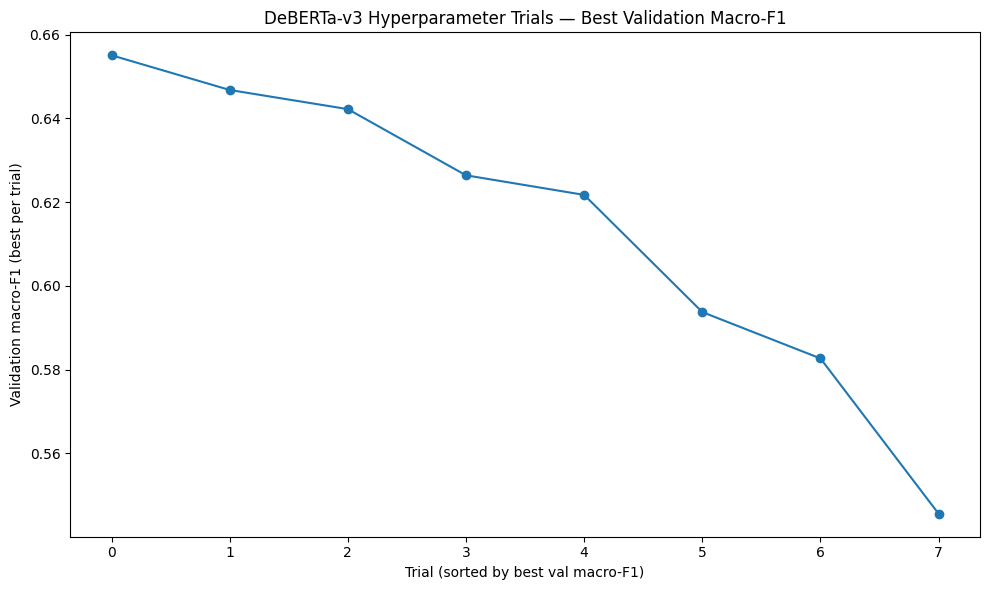

Saved: tuning_debertav3_20250817_221015/val_macro_f1_best_by_trial.png


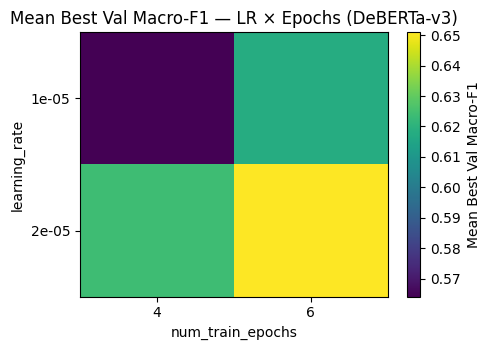

Saved: tuning_debertav3_20250817_221015/heatmap_lr_epochs.png


In [10]:
#Sorted by best val macro-F1
plt.figure(figsize=(10,6))
plt.plot(res_df["val_macro_f1_best"].values, marker="o")
plt.ylabel("Validation macro-F1 (best per trial)")
plt.xlabel("Trial (sorted by best val macro-F1)")
plt.title("DeBERTa-v3 Hyperparameter Trials — Best Validation Macro-F1")
plt.tight_layout()
fig1 = os.path.join(out_root, "val_macro_f1_best_by_trial.png")
plt.savefig(fig1, dpi=150)
plt.show()
print(f"Saved: {fig1}")
#Heatmap: learning_rate × num_train_epochs (mean over other parameters)
pivot = (res_df
         .groupby(["learning_rate","num_train_epochs"])["val_macro_f1_best"]
         .mean()
         .reset_index()
         .pivot(index="learning_rate", columns="num_train_epochs", values="val_macro_f1_best"))
plt.figure(figsize=(5,3.6))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(pivot.shape[1]), pivot.columns)
plt.yticks(range(pivot.shape[0]), [f"{v:.0e}" for v in pivot.index])
plt.colorbar(label="Mean Best Val Macro-F1")
plt.xlabel("num_train_epochs")
plt.ylabel("learning_rate")
plt.title("Mean Best Val Macro-F1 — LR × Epochs (DeBERTa-v3)")
plt.tight_layout()
fig2 = os.path.join(out_root, "heatmap_lr_epochs.png")
plt.savefig(fig2, dpi=150)
plt.show()
print(f"Saved: {fig2}")